In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

from sklearn.linear_model import LinearRegression


In [19]:
import asyncio
import motor.motor_asyncio
import nest_asyncio
nest_asyncio.apply()

from datetime import date, datetime, timedelta
import pprint
import sys
import os
import requests

sys.path.insert(0, os.path.abspath('../'))
import abupy
from abupy.UtilBu.ABuDateUtil import str_to_datetime

In [6]:
client = motor.motor_asyncio.AsyncIOMotorClient('mongodb://localhost:27017')
loop = asyncio.get_event_loop()

db = client['symbol-db']
collection = db['StockHisTrader']

In [15]:
yy, mm, dd = date.today().isoformat().split("-")[0:3]
#dd = 19
cdate = "{0}-{1}-{2}".format(yy, mm, dd)
today = str_to_datetime(cdate)

symbol = '2330'
short_sampleD = 20
short_endD = today #datetime.now()
short_startD = datetime.now() - timedelta(days=short_sampleD)    

In [16]:
# internal db 
async def get_symbol_OHLCV_df(symbol, startD, endD):
    pipeline = [
        {"$match":{ "$expr": {"$and": [
                { "$lte": ["$date", endD ] },
                { "$gte": ["$date", startD ] },
                { "$eq": ["$symbol", symbol ] }
            ]}}},
         {"$project" : { "_id": 0 } }
        ]
    collect = db['StockHisData'].aggregate(pipeline)
    items = await collect.to_list(100)
    df = pd.DataFrame(items)
    df = df.set_index('date')
    return df
 
df0 = loop.run_until_complete(get_symbol_OHLCV_df(symbol, short_startD, short_endD))
df0.head()

,O,H,L,C,V,symbol
date,,,,,,
2021-03-22,588.0,598.0,586.0,593.0,37802.0,2330
2021-03-23,597.0,603.0,593.0,594.0,34538.0,2330
2021-03-24,571.0,582.0,571.0,576.0,123706.0,2330
2021-03-25,572.0,581.0,570.0,575.0,80688.0,2330
2021-03-26,582.0,592.0,580.0,590.0,39110.0,2330


In [17]:
df0.shape

(12, 6)

In [58]:
#internet 
url = "https://api.finmindtrade.com/api/v4/data"
parameter = {
    "dataset": "TaiwanStockPrice",
    "data_id": symbol,
    "start_date": "2020-01-01",
    "token": "", # 參考登入，獲取金鑰
}
data = requests.get(url, params=parameter)
data = data.json()
data = pd.DataFrame(data['data'])
#data
data.head()
df = data['close']
df.index = pd.to_datetime(data['date'])
df.dtypes

dtype('float64')

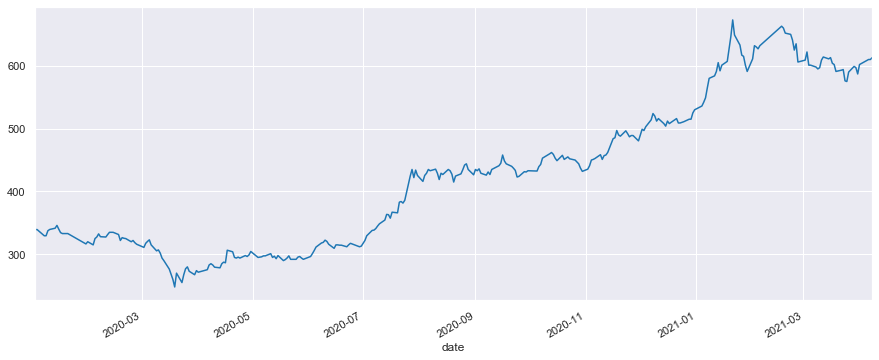

In [59]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

In [60]:
df_melted = pd.DataFrame({"close": df.copy()})
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "2330"
df_melted = df_melted.rename_axis(['idate'])
df_melted.head()

,close,date,Symbols
idate,,,
2020-01-02,339.0,2020-01-02,2330
2020-01-03,339.5,2020-01-03,2330
2020-01-06,332.0,2020-01-06,2330
2020-01-07,329.5,2020-01-07,2330
2020-01-08,329.5,2020-01-08,2330


In [61]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:454: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn("Your time stamps are not uniformly sampled, which makes rolling "
Rolling: 100%|█████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.88it/s]


In [62]:
df_rolled.tail()

,close,date,Symbols,id
6154,587.0,2021-03-31,2330,"(2330, 2021-04-08 00:00:00)"
6155,602.0,2021-04-01,2330,"(2330, 2021-04-08 00:00:00)"
6156,610.0,2021-04-06,2330,"(2330, 2021-04-08 00:00:00)"
6157,610.0,2021-04-07,2330,"(2330, 2021-04-08 00:00:00)"
6158,613.0,2021-04-08,2330,"(2330, 2021-04-08 00:00:00)"


In [65]:
df_rolled[df_rolled["id"] == ("2330", pd.to_datetime("2020-07-14"))]

,close,date,Symbols,id
2400,316.0,2020-06-12,2330,"(2330, 2020-07-14 00:00:00)"
2401,309.5,2020-06-15,2330,"(2330, 2020-07-14 00:00:00)"
2402,315.0,2020-06-16,2330,"(2330, 2020-07-14 00:00:00)"
2403,315.0,2020-06-17,2330,"(2330, 2020-07-14 00:00:00)"
2404,314.5,2020-06-18,2330,"(2330, 2020-07-14 00:00:00)"
...,...,...,...,...
2416,341.0,2020-07-08,2330,"(2330, 2020-07-14 00:00:00)"
2417,345.0,2020-07-09,2330,"(2330, 2020-07-14 00:00:00)"
2418,348.5,2020-07-10,2330,"(2330, 2020-07-14 00:00:00)"
2419,354.5,2020-07-13,2330,"(2330, 2020-07-14 00:00:00)"


In [64]:
df_melted[(df_melted["date"] <= pd.to_datetime("2020-07-14")) & 
          (df_melted["date"] >= pd.to_datetime("2020-06-15")) & 
          (df_melted["Symbols"] == "2330")]

,close,date,Symbols
idate,,,
2020-06-15,309.5,2020-06-15,2330
2020-06-16,315.0,2020-06-16,2330
2020-06-17,315.0,2020-06-17,2330
2020-06-18,314.5,2020-06-18,2330
2020-06-19,314.5,2020-06-19,2330
2020-06-22,312.0,2020-06-22,2330
2020-06-23,315.0,2020-06-23,2330
2020-06-24,317.5,2020-06-24,2330
2020-06-29,312.0,2020-06-29,2330


In [66]:
len(df_melted)

304

In [67]:
df_rolled["id"].nunique()

299

In [68]:
df_rolled.groupby("id").size().agg([np.min, np.max])

amin     6
amax    21
dtype: int64

In [69]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="date", column_value="close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


In [70]:
X.head()

close__variance_larger_than_standard_deviation  \
2330 2020-01-09                                             1.0   
     2020-01-10                                             1.0   
     2020-01-13                                             1.0   
     2020-01-14                                             1.0   
     2020-01-15                                             1.0   

                 close__has_duplicate_max  close__has_duplicate_min  \
2330 2020-01-09                       0.0                       1.0   
     2020-01-10                       1.0                       1.0   
     2020-01-13                       0.0                       1.0   
     2020-01-14                       0.0                       1.0   
     2020-01-15                       0.0                       1.0   

                 close__has_duplicate  close__sum_values  close__abs_energy  \
2330 2020-01-09                   1.0             2007.0         6.7145e+05   
     2020-01-10                   1.0             2346.5         7.8671e+05   
     2020-01-13                   1.0             2688.0         9.0333e+05   
     2020-01-14                   1.0             3034.0         1.0231e+06   
     2020-01-15                   1.0             3374.0         1.1387e+06   

                 close__mean_abs_change  close__mean_change  \
2330 2020-01-09                  3.7000             -0.3000   
     2020-01-10                  3.4167              0.0833   
     2020-01-13                  3.2143              0.3571   
     2020-01-14                  3.3750              0.8750   
     2020-01-15                  3.6667              0.1111   

                 close__mean_second_derivative_central  close__median  ...  \
2330 2020-01-09                                 0.9375         334.75  ...   
     2020-01-10                                 0.1500         337.50  ...   
     2020-01-13                                 0.1250         338.25  ...   
     2020-01-14                                 0.2857         339.00  ...   
     2020-01-15                                -0.4062         339.25  ...   

                 close__fourier_entropy__bins_2  \
2330 2020-01-09                          0.5623   
     2020-01-10                          0.5623   
     2020-01-13                          0.5004   
     2020-01-14                          0.5004   
     2020-01-15                          0.4506   

                 close__fourier_entropy__bins_3  \
2330 2020-01-09                          1.0397   
     2020-01-10                          1.0397   
     2020-01-13                          0.9503   
     2020-01-14                          0.5004   
     2020-01-15                          0.4506   

                 close__fourier_entropy__bins_5  \
2330 2020-01-09                          1.0397   
     2020-01-10                          1.0397   
     2020-01-13                          1.3322   
     2020-01-14                          0.9503   
     2020-01-15                          0.8676   

                 close__fourier_entropy__bins_10  \
2330 2020-01-09                           1.3863   
     2020-01-10                           1.0397   
     2020-01-13                           1.3322   
     2020-01-14                           1.3322   
     2020-01-15                           0.8676   

                 close__fourier_entropy__bins_100  \
2330 2020-01-09                            1.3863   
     2020-01-10                            1.3863   
     2020-01-13                            1.3322   
     2020-01-14                            1.6094   
     2020-01-15                            1.5607   

                 close__permutation_entropy__dimension_3__tau_1  \
2330 2020-01-09                                          1.3863   
     2020-01-10                                          1.3322   
     2020-01-13                                          1.2425   
     2020-01-14                            

In [71]:

X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_2,close__fourier_entropy__bins_3,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1
last_date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,1.0,0.0,1.0,1.0,2007.0,6.7145e+05,3.7000,-0.3000,0.9375,334.75,...,0.5623,1.0397,1.0397,1.3863,1.3863,1.3863,1.0986,0.6931,-0.0000,2.7081
2020-01-10,1.0,1.0,1.0,1.0,2346.5,7.8671e+05,3.4167,0.0833,0.1500,337.50,...,0.5623,1.0397,1.0397,1.0397,1.3863,1.3322,1.3863,1.0986,0.6931,-0.0000
2020-01-13,1.0,0.0,1.0,1.0,2688.0,9.0333e+05,3.2143,0.3571,0.1250,338.25,...,0.5004,0.9503,1.3322,1.3322,1.3322,1.2425,1.3322,1.3863,1.0986,0.6931
2020-01-14,1.0,0.0,1.0,1.0,3034.0,1.0231e+06,3.3750,0.8750,0.2857,339.00,...,0.5004,0.5004,0.9503,1.3322,1.6094,1.1537,1.2425,1.3322,1.3863,1.0986
2020-01-15,1.0,0.0,1.0,1.0,3374.0,1.1387e+06,3.6667,0.1111,-0.4062,339.25,...,0.4506,0.4506,0.8676,0.8676,1.5607,1.2130,1.4751,1.5607,1.6094,1.3863


In [72]:
X.loc['2020-07-14']

close__variance_larger_than_standard_deviation       1.0000
close__has_duplicate_max                             0.0000
close__has_duplicate_min                             0.0000
close__has_duplicate                                 1.0000
close__sum_values                                 6852.0000
                                                    ...    
close__permutation_entropy__dimension_3__tau_1       1.0281
close__permutation_entropy__dimension_4__tau_1       1.6377
close__permutation_entropy__dimension_5__tau_1       1.7731
close__permutation_entropy__dimension_6__tau_1       1.9213
close__permutation_entropy__dimension_7__tau_1       1.9913
Name: 2020-07-14 00:00:00, Length: 779, dtype: float64

In [73]:
y = df_melted.set_index("date").sort_index().close.shift(-1)

In [79]:
y["2020-07-13"]


363.5

In [77]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [84]:
X[:"2020-06-30"].head()

,close__variance_larger_than_standard_deviation,close__has_duplicate_max,close__has_duplicate_min,close__has_duplicate,close__sum_values,close__abs_energy,close__mean_abs_change,close__mean_change,close__mean_second_derivative_central,close__median,...,close__fourier_entropy__bins_2,close__fourier_entropy__bins_3,close__fourier_entropy__bins_5,close__fourier_entropy__bins_10,close__fourier_entropy__bins_100,close__permutation_entropy__dimension_3__tau_1,close__permutation_entropy__dimension_4__tau_1,close__permutation_entropy__dimension_5__tau_1,close__permutation_entropy__dimension_6__tau_1,close__permutation_entropy__dimension_7__tau_1
last_date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,1.0,0.0,1.0,1.0,2007.0,6.7145e+05,3.7000,-0.3000,0.9375,334.75,...,0.5623,1.0397,1.0397,1.3863,1.3863,1.3863,1.0986,0.6931,-0.0000,2.7081
2020-01-10,1.0,1.0,1.0,1.0,2346.5,7.8671e+05,3.4167,0.0833,0.1500,337.50,...,0.5623,1.0397,1.0397,1.0397,1.3863,1.3322,1.3863,1.0986,0.6931,-0.0000
2020-01-13,1.0,0.0,1.0,1.0,2688.0,9.0333e+05,3.2143,0.3571,0.1250,338.25,...,0.5004,0.9503,1.3322,1.3322,1.3322,1.2425,1.3322,1.3863,1.0986,0.6931
2020-01-14,1.0,0.0,1.0,1.0,3034.0,1.0231e+06,3.3750,0.8750,0.2857,339.00,...,0.5004,0.5004,0.9503,1.3322,1.6094,1.1537,1.2425,1.3322,1.3863,1.0986
2020-01-15,1.0,0.0,1.0,1.0,3374.0,1.1387e+06,3.6667,0.1111,-0.4062,339.25,...,0.4506,0.4506,0.8676,0.8676,1.5607,1.2130,1.4751,1.5607,1.6094,1.3863


In [85]:
X_train = X[:"2020-06-30"]
X_test = X["2020-07-01":]

y_train = y[:"2020-06-30"]
y_test = y["2020-07-01":]

In [86]:
X_train_selected = select_features(X_train, y_train)

In [87]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train)

LinearRegression()